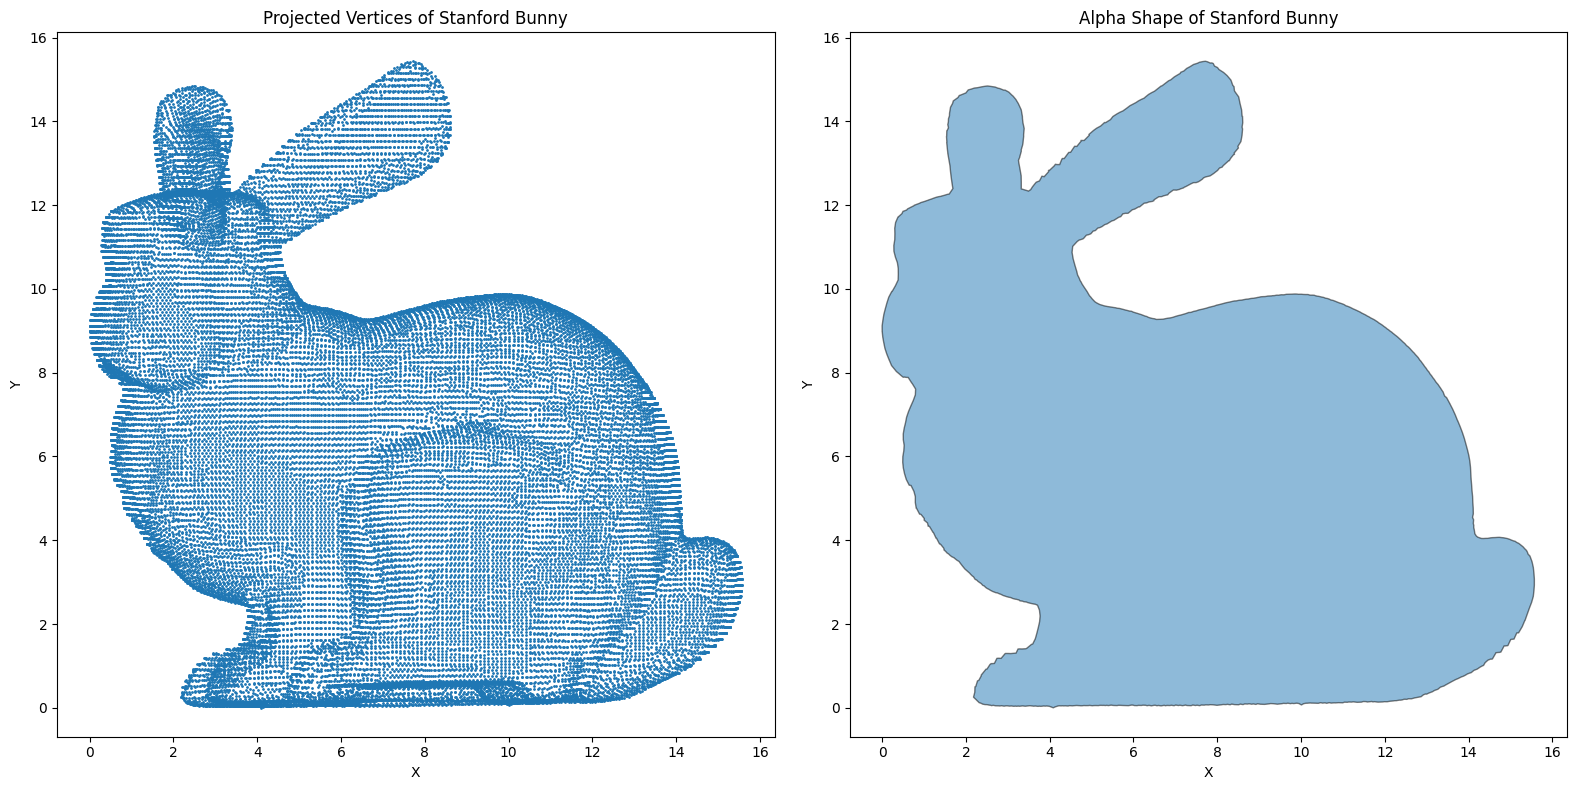

In [2]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import alphashape

bunny = trimesh.load("Resources/stanford-bunny.obj")
vertices_2d = bunny.vertices[:, :2] * 100# Take only X and Y coordinates

#shift vertices to positive values
min_x = np.min(vertices_2d[:, 0])
min_y = np.min(vertices_2d[:, 1])
vertices_2d[:, 0] -= min_x
vertices_2d[:, 1] -= min_y


#print(vertices_2d)
#vertices_2d = vertices_2d * 30

alpha_shape = alphashape.alphashape(vertices_2d, 10)


fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(*zip(*vertices_2d), s=1, label="Projected Vertices")
axs[0].set_title("Projected Vertices of Stanford Bunny")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")

#axs[1].scatter(*zip(*vertices_2d))
axs[1].add_patch(PolygonPatch(alpha_shape, alpha=0.5))
axs[1].set_title("Alpha Shape of Stanford Bunny")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")

# Show the figure
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import alphashape

from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

gridsize = 100


# Create a grid of points (for example, a 500x500 grid within the bounding box)
x_min, y_min, x_max, y_max = alpha_shape.bounds

grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, gridsize), np.linspace(y_min, y_max, gridsize))

# Flatten the grid to compute the distance for each point
grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# Create an array to store the signed distances
signed_distances = np.zeros(grid_points.shape[0])

# Ray-casting to determine if the point is inside or outside
def ray_casting(point, shape):
    # Cast rays in multiple directions
    ray_length = 1000  # Length of the ray
    directions = [
        (point[0] + ray_length, point[1]),  # Positive X direction
        (point[0] - ray_length, point[1]),  # Negative X direction
        (point[0], point[1] + ray_length),  # Positive Y direction
        (point[0], point[1] - ray_length),  # Negative Y direction
        (point[0] + ray_length, point[1] + ray_length),  # Diagonal top-right
        (point[0] - ray_length, point[1] - ray_length),  # Diagonal bottom-left
    ]
    
    # Initialize the highest intersection count
    highest_intersections = 0

    # Check for intersections with the boundary in any of the directions
    for direction in directions:
        ray = LineString([point, direction]) # Extend the ray far away
        intersections = shape.boundary.intersection(ray)
        
        if intersections.geom_type == 'Point':
            num_intersections = 1
        elif intersections.geom_type == 'MultiPoint':
            num_intersections = len(intersections.geoms)
        elif intersections.geom_type == 'LineString':
            # For LineString, we can count the number of points or segments
            num_intersections = 0
        
        highest_intersections = max(highest_intersections, num_intersections)

    # If the highest number of intersections is odd, the point is inside; otherwise, outside
    return highest_intersections

# Compute the signed distance for each grid point
for i, point in enumerate(grid_points):
    point_shapely = Point(point[0], point[1])
    
    # Compute the shortest distance to the boundary
    distance_to_boundary = point_shapely.distance(alpha_shape.boundary)
    
    # Use ray-casting to determine if the point is inside or outside
    if ray_casting(point, alpha_shape) % 2 == 1:
        signed_distances[i] = -distance_to_boundary  # Inside, negative distance
    else:
        signed_distances[i] = distance_to_boundary  # Outside, positive distance

# Reshape the signed distances back to a 2D grid for visualization
signed_distances = signed_distances.reshape(grid_x.shape)




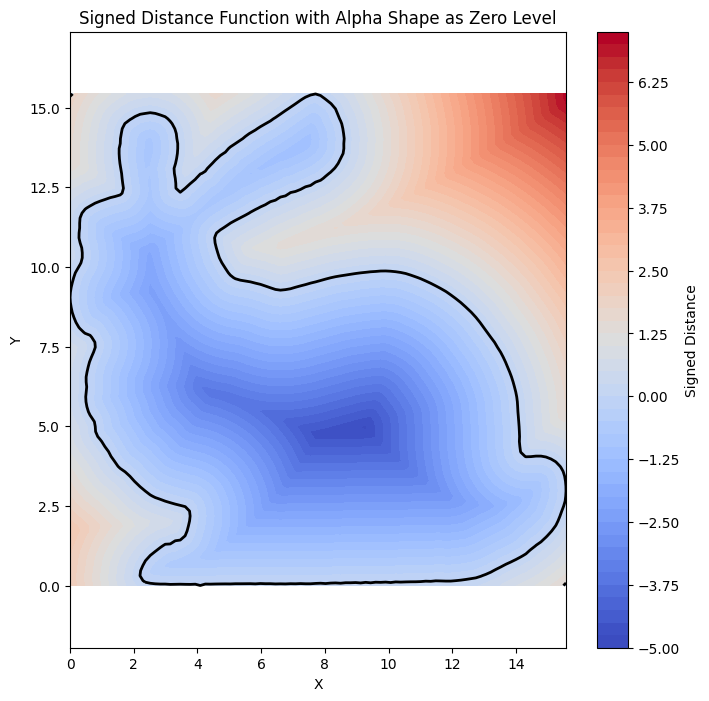

In [4]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

# Create a figure for visualization
plt.figure(figsize=(8, 8))

# Normalize the signed distances so that zero is the center
norm = matplotlib.colors.Normalize(vmin=np.min(signed_distances), vmax=np.max(signed_distances))

# Plot the SDF with the centered colormap
contour = plt.contourf(grid_x, grid_y, signed_distances, levels=50, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

# Plot the zero level contour in black
plt.contour(grid_x, grid_y, signed_distances, levels=[0], colors='black', linewidths=2)



# Set the plot title and labels
plt.title("Signed Distance Function with Alpha Shape as Zero Level")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
# Show the plot
plt.show()


In [5]:
import numpy as np
import torch

# Grid size
gridsize = 100

# Create a grid of points (for example, a 100x100 grid within the bounding box of the alpha shape)
x_min, y_min, x_max, y_max = alpha_shape.bounds  # Assuming `alpha_shape` is already defined
grid_x, grid_y = torch.meshgrid(
    torch.linspace(x_min, x_max, gridsize),
    torch.linspace(y_min, y_max, gridsize),
    indexing="ij"  # Match the shape of `meshgrid` in NumPy
)

# Flatten the grid to create input points
grid_points = torch.stack([grid_x.ravel(), grid_y.ravel()], dim=1)  # Shape: (gridsize^2, 2)



In [6]:
def bunny_sdf(vertices):
    import trimesh
    import alphashape
    from shapely.geometry import Point, LineString    
    # Ray-casting to determine if the point is inside or outside
    def ray_casting(point, shape):
        import numpy as np
        from shapely.geometry import LineString, MultiLineString

        ray_length = 1000  # Length of the ray
        # Define all directions as a NumPy array
        directions = np.array([
            [ray_length, 0],   # Positive X
            [-ray_length, 0],  # Negative X
            [0, ray_length],   # Positive Y
            [0, -ray_length],  # Negative Y
            [ray_length, ray_length],  # Diagonal top-right
            [-ray_length, -ray_length]  # Diagonal bottom-left
        ])

        rays = [LineString([point, point + direction]) for direction in directions]

        intersections = [shape.boundary.intersection(ray) for ray in rays]

        # Compute the number of intersections for each ray
        intersection_counts = []
        for intersection in intersections:
            if intersection.geom_type == "Point":
                intersection_counts.append(1)
            elif intersection.geom_type == "MultiPoint":
                intersection_counts.append(len(intersection.geoms))
            else:  # No valid intersection
                intersection_counts.append(0)

        # Return the maximum number of intersections across all rays
        highest_intersections = max(intersection_counts)
        return highest_intersections
        
    bunny = trimesh.load("Resources/stanford-bunny.obj")
    bunny_2dvertices = bunny.vertices[:, :2] * 100 # Take only X and Y coordinates
    
    #shift vertices to positive values
    min_x = np.min(bunny_2dvertices[:, 0])
    min_y = np.min(bunny_2dvertices[:, 1])
    bunny_2dvertices[:, 0] -= min_x
    bunny_2dvertices[:, 1] -= min_y

    alpha_shape = alphashape.alphashape(bunny_2dvertices, 10)

    sdf_values = torch.zeros(vertices.shape[0])

    # Compute the signed distance for each vertices
    for i, point in enumerate(vertices):
        point_shapely = Point(point[0], point[1])
        
        # Compute the shortest distance to the boundary
        distance_to_boundary = point_shapely.distance(alpha_shape.boundary)
        
        # Use ray-casting to determine if the point is inside or outside
        if ray_casting(point, alpha_shape) % 2 == 1:
            sdf_values[i] = -distance_to_boundary  # Inside, negative distance
        else:
            sdf_values[i] = distance_to_boundary  # Outside, positive distance


    return sdf_values



In [7]:

# Example: Compute signed distance for the grid points
sdf_values = bunny_sdf(grid_points)

# Reshape the SDF values back to the grid for visualization
sdf_grid = sdf_values.view(gridsize, gridsize)

# Optionally, convert to NumPy for plotting
sdf_grid_np = sdf_grid.cpu().numpy()

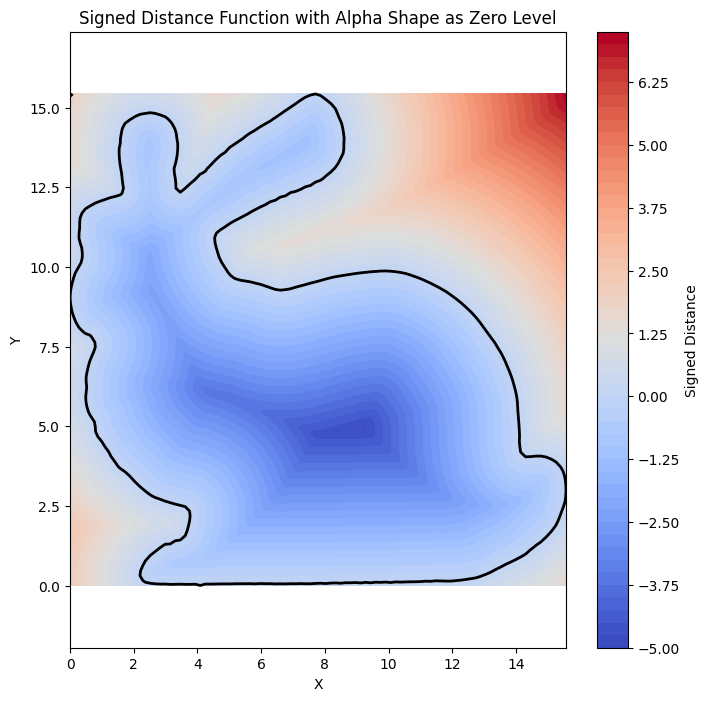

In [8]:

# Create a figure for visualization
plt.figure(figsize=(8, 8))

# Normalize the signed distances so that zero is the center
norm = matplotlib.colors.Normalize(vmin=np.min(sdf_grid_np), vmax=np.max(sdf_grid_np))

# Plot the SDF with the centered colormap
contour = plt.contourf(grid_x, grid_y, sdf_grid_np, levels=50, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

# Plot the zero level contour in black
plt.contour(grid_x, grid_y, sdf_grid_np, levels=[0], colors='black', linewidths=2)



# Set the plot title and labels
plt.title("Signed Distance Function with Alpha Shape as Zero Level")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
# Show the plot
plt.show()

In [9]:
import torch
import numpy as np

# Define grid resolution
resolution = 256
x = torch.linspace(-1, 1, resolution)
y = torch.linspace(-1, 1, resolution)
xx, yy = torch.meshgrid(x, y)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=-1)
sdf_values = bunny_sdf(grid_points)  # Compute SDF values for grid
sdf_grid = sdf_values.view(resolution, resolution)  # Reshape to grid

from torch.nn.functional import grid_sample

def differentiable_sdf(points, sdf_grid, resolution):
    # Normalize points to the grid range [-1, 1]
    points_normalized = points * 2 / resolution - 1
    points_normalized = points_normalized.unsqueeze(0).unsqueeze(0)  # Add batch dims
    sdf_interpolated = grid_sample(
        sdf_grid.unsqueeze(0).unsqueeze(0), points_normalized, align_corners=True
    )
    return sdf_interpolated.squeeze()


KeyboardInterrupt: 